In [1]:
%ls

dev-0.ipynb  dev-2.ipynb  html.gv      __pycache__/   tables-1-bis.html
dev-1.ipynb  dev_2.py     html.gv.pdf  tables-0.html  tables-1.html


In [2]:
%%writefile dev_2.py
import lxml
import lxml.html
import lxml.etree
import os
from collections import defaultdict
from graphviz import Digraph


HIERARCHICAL = 'hierarchical'
SEQUENTIAL = 'sequential'


def open_doc(folder, filename):
    folder = os.path.abspath(folder)
    filepath = os.path.join(folder, filename)

    with open(filepath, 'r') as file:
        doc = lxml.html.fromstring(
            lxml.etree.tostring(
                lxml.html.parse(file), method='html'
            )
        )
    return doc


def html_to_dot_sequential_name(html, with_text=False):
    graph = Digraph(name='html')
    tag_counts = defaultdict(int)
    
    def add_node(html_node):
        tag = html_node.tag
        tag_sequential = tag_counts[tag]
        tag_counts[tag] += 1
        node_name = "{}-{}".format(tag, tag_sequential)
        graph.node(node_name, node_name)
        
        if len(html_node) > 0:
            for child in html_node.iterchildren():
                child_name = add_node(child)
                graph.edge(node_name, child_name)
        else:
            child_name = "-".join([node_name, "txt"])
            graph.node(child_name, html_node.text)
            graph.edge(node_name, child_name)
        return node_name
    add_node(html)
    return graph


def html_to_dot_hierarchical_name(html, with_text=False):
    graph = Digraph(name='html')
    
    def add_node(html_node, parent_suffix, brotherhood_index):
        tag = html_node.tag
        if parent_suffix is None and brotherhood_index is None:
            node_suffix = ""
            node_name = tag
        else:
            node_suffix = (
                "-".join([parent_suffix, str(brotherhood_index)]) 
                if parent_suffix else 
                str(brotherhood_index)
            )
            node_name = "{}-{}".format(tag, node_suffix)
        graph.node(node_name, node_name, path=node_suffix)
        
        if len(html_node) > 0:
            for child_index, child in enumerate(html_node.iterchildren()):
                child_name = add_node(child, node_suffix, child_index)
                graph.edge(node_name, child_name)
        else:
            child_name = "-".join([node_name, "txt"])
            child_path = "-".join([node_suffix, "txt"])
            graph.node(child_name, html_node.text, path=child_path)
            graph.edge(node_name, child_name)
        return node_name
    add_node(html, None, None)
    return graph


def html_to_dot(html, name_option='hierarchical', with_text=False):
    if name_option == SEQUENTIAL:
        return html_to_dot_sequential_name(html, with_text=with_text)
    elif name_option == HIERARCHICAL:
        return html_to_dot_hierarchical_name(html, with_text=with_text)
    else:
        raise Exception('No name option `{}`'.format(name_option))
        

Overwriting dev_2.py


In [3]:
%load_ext autoreload
%autoreload 2
from dev_2 import open_doc, html_to_dot, SEQUENTIAL
folder = '.'
filename = 'tables-1.html'
doc = open_doc(folder, filename)
dot = html_to_dot(doc, name_option=SEQUENTIAL)

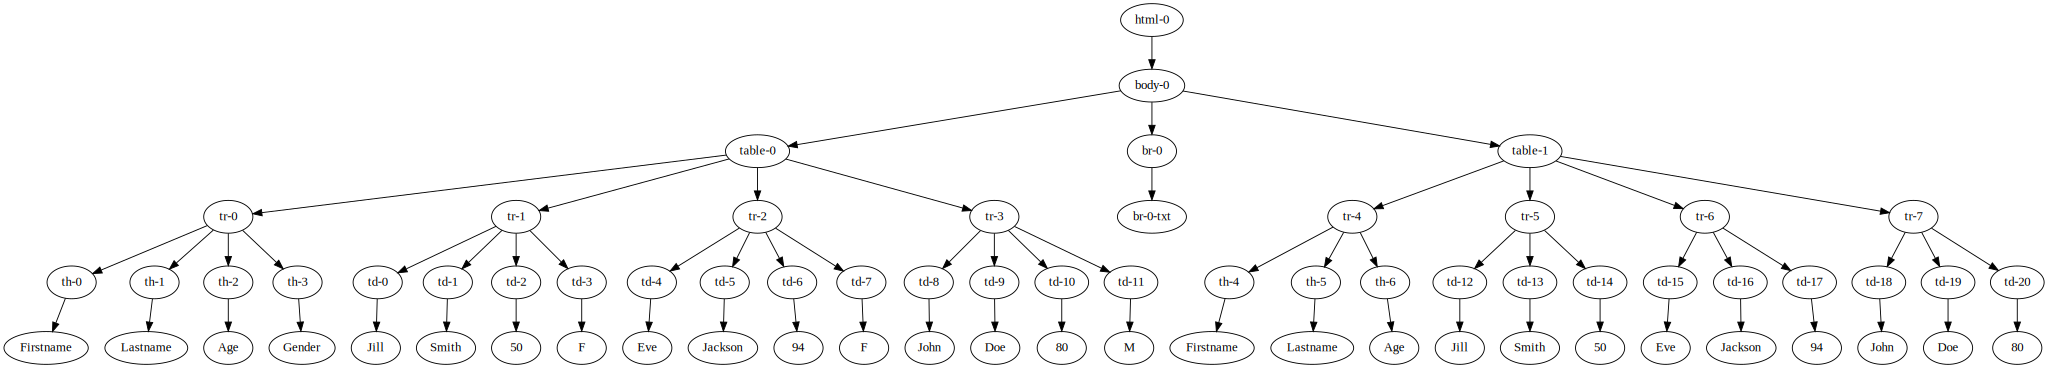

In [4]:
dot

In [5]:
dot.view(filename + '.pdf')

'tables-1.html.pdf.pdf'

In [6]:
def depth(node):
    d = 0
    while node is not None:
        d += 1
        node = node.getparent()
    return d

In [7]:
import json
dic = {1: 0, 0: 1}
sdic = json.dumps(dic)
usdic = json.loads(sdic)

In [8]:
dic

{1: 0, 0: 1}

In [9]:
sdic

'{"1": 0, "0": 1}'

In [10]:
usdic

{'1': 0, '0': 1}

In [11]:
import yaml
dic = {1: 0, 0: 1}
sdic = yaml.dump(dic)
usdic = yaml.full_load(sdic)

In [12]:
dic

{1: 0, 0: 1}

In [13]:
sdic

'0: 1\n1: 0\n'

In [14]:
usdic

{0: 1, 1: 0}

In [15]:
import yaml
from similarity.normalized_levenshtein import NormalizedLevenshtein
import lxml
import lxml.etree
from pprint import pprint
from collections import defaultdict


normalized_levenshtein = NormalizedLevenshtein()


MINIMUM_DEPTH = 3


class MDR:
    
    def __init__(self, K):
        self.K = K
        self.tag_counts = defaultdict(int)
    
    def __call__(self, node):
        tag = node.tag
        tag_name = "{}-{}".format(tag, self.tag_counts[tag])
        self.tag_counts[tag] += 1
        print(tag_name)
        self.distances = {}
        node_depth = depth(node)
        if node_depth >= MINIMUM_DEPTH:
            distances = self.compare_combinations(node.getchildren()) 
            print("\n{} - distances".format(tag_name))
            pprint(distances)
            # todo: eventually install lib yaml for speed up
            # https://pyyaml.org/wiki/PyYAMLDocumentation
            node.set('distances', yaml.dump(distances))
        print("\n\n\n")
        for child in node:
            self(child)
    
    def compare_combinations(self, node_list):
        if not node_list:
            return {}
        print('in compare_combinations')
        distances = {}
        n = len(node_list)
        # for (i = 1; i <= K; i++)  /* start from each node */
        for i in range(1, self.K + 1):
            print('i', i)
            # for (j = i; j <= K; j++) /* comparing different combinations
            for j in range(i, self.K + 1):
                print('\tj', j)
                # if NodeList[i+2*j-1] exists then
                if (i + 2*j - 1) < n + 1:  # +1 for pythons open set notation
                    print('\tif-1 ok')
                    st = i
                    # for (k = i+j; k < Size(NodeList); k+j)
                    # for k in range(i + j, n, j):
                    for k in range(i + j, n + 1, j):
                        print('\t\tst', st)
                        print('\t\tk', k)
                        # if NodeList[k+j-1] exists then
                        if k + j - 1 < n + 1:
                            print('\t\tif-2 ok')
                            # todo: avoid recomputing strings
                            # todo: avoid recomputing edit distances
                            # todo: check https://pypi.org/project/strsim/
                            # NodeList[St..(k-1)]
                            left = (st - 1, k -1 -1)
                            print('\t\tleft', left)
                            str_left = MDR.list_nodes_to_string(node_list[left[0]:left[1]])
                            # NodeList[St..(k-1)]
                            right = (k -1, k + j -1 -1)
                            print('\t\tright', right)
                            str_right = MDR.list_nodes_to_string(node_list[right[0]:right[1]])
                            # edit distance
                            dist = normalized_levenshtein.distance(str_left, str_right)
                            print('\t\tdist', dist)
                            distances[str((left, right))] = dist
                            st = k
                            print(' ')
        return distances
                            
    @staticmethod
    def list_nodes_to_string(list_of_nodes):
        return b" ".join([
            lxml.etree.tostring(child) for child in list_of_nodes
        ])

In [18]:
mdr = MDR(K=3)
mdr(doc)

html-0




body-0




table-0
in compare_combinations
i 1
	j 1
	if-1 ok
		st 1
		k 2
		if-2 ok
		left (0, 0)
		right (1, 1)
		dist 0.0
 
		st 2
		k 3
		if-2 ok
		left (1, 1)
		right (2, 2)
		dist 0.0
 
		st 3
		k 4
		if-2 ok
		left (2, 2)
		right (3, 3)
		dist 0.0
 
	j 2
	if-1 ok
		st 1
		k 3
		if-2 ok
		left (0, 1)
		right (2, 3)
		dist 0.32989690721649484
 
	j 3
i 2
	j 2
	j 3
i 3
	j 3

table-0 - distances
{'((0, 0), (1, 1))': 0.0,
 '((0, 1), (2, 3))': 0.32989690721649484,
 '((1, 1), (2, 2))': 0.0,
 '((2, 2), (3, 3))': 0.0}




tr-0
in compare_combinations
i 1
	j 1
	if-1 ok
		st 1
		k 2
		if-2 ok
		left (0, 0)
		right (1, 1)
		dist 0.0
 
		st 2
		k 3
		if-2 ok
		left (1, 1)
		right (2, 2)
		dist 0.0
 
		st 3
		k 4
		if-2 ok
		left (2, 2)
		right (3, 3)
		dist 0.0
 
	j 2
	if-1 ok
		st 1
		k 3
		if-2 ok
		left (0, 1)
		right (2, 3)
		dist 0.34782608695652173
 
	j 3
i 2
	j 2
	j 3
i 3
	j 3

tr-0 - distances
{'((0, 0), (1, 1))': 0.0,
 '((0, 1), (2, 3))': 0.34782608695652173,
 '((1, 1), (2,

In [23]:
%load_ext autoreload
%autoreload 2
from dev_2 import open_doc, html_to_dot, SEQUENTIAL
folder = '.'
filename = 'tables-1-bis.html'
doc = open_doc(folder, filename)
dot = html_to_dot(doc, name_option=SEQUENTIAL)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


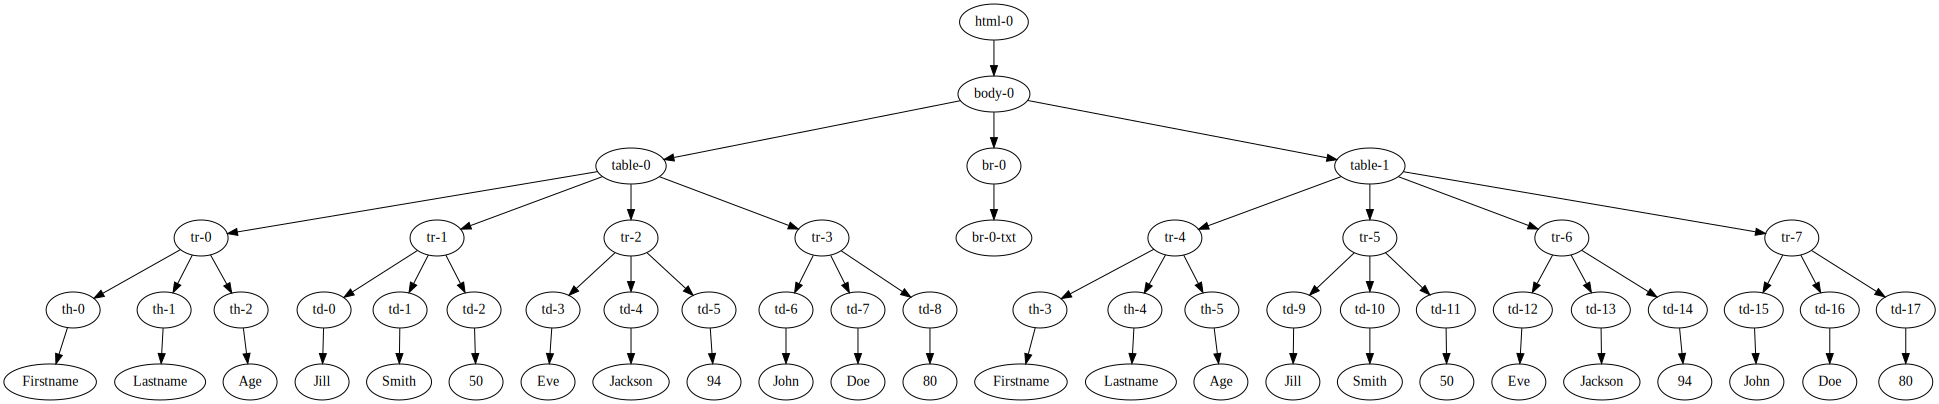

In [24]:
dot

In [25]:
dot.view(filename + '.pdf')

'tables-1-bis.html.pdf.pdf'

In [22]:
mdr = MDR(K=3)
mdr(doc)

html-0




body-0




table-0
in compare_combinations
i 1
	j 1
	if-1 ok
		st 1
		k 2
		if-2 ok
		left (0, 0)
		right (1, 1)
		dist 0.0
 
		st 2
		k 3
		if-2 ok
		left (1, 1)
		right (2, 2)
		dist 0.0
 
		st 3
		k 4
		if-2 ok
		left (2, 2)
		right (3, 3)
		dist 0.0
 
	j 2
	if-1 ok
		st 1
		k 3
		if-2 ok
		left (0, 1)
		right (2, 3)
		dist 0.3116883116883117
 
	j 3
i 2
	j 2
	j 3
i 3
	j 3

table-0 - distances
{'((0, 0), (1, 1))': 0.0,
 '((0, 1), (2, 3))': 0.3116883116883117,
 '((1, 1), (2, 2))': 0.0,
 '((2, 2), (3, 3))': 0.0}




tr-0
in compare_combinations
i 1
	j 1
	if-1 ok
		st 1
		k 2
		if-2 ok
		left (0, 0)
		right (1, 1)
		dist 0.0
 
		st 2
		k 3
		if-2 ok
		left (1, 1)
		right (2, 2)
		dist 0.0
 
	j 2
	j 3
i 2
	j 2
	j 3
i 3
	j 3

tr-0 - distances
{'((0, 0), (1, 1))': 0.0, '((1, 1), (2, 2))': 0.0}




th-0

th-0 - distances
{}




th-1

th-1 - distances
{}




th-2

th-2 - distances
{}




tr-1
in compare_combinations
i 1
	j 1
	if-1 ok
		st 1
		k 2
		if-2 ok
		left (0, 0)
		right (1